In [1]:
#Loading in libraries
pacman::p_load(tidyverse, dplyr, ggplot2, cowplot, ggthemes, RColorBrewer, fastDummies, janitor, MLmetrics, magick,
               repr, BBmisc, devtools, reticulate, Rcpp, tictoc, data.table, corrplot, ggrepel, cvAUC, e1071, resample)


#Loading in train data
df_train <- read.csv("../input/tabular-playground-series-may-2022/train.csv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


resample installed



In [2]:
reticulate::py_discover_config("h2o4gpu")
reticulate::conda_version(conda = "auto")

python:         /miniconda/envs/r-reticulate/bin/python
libpython:      /miniconda/envs/r-reticulate/lib/libpython3.7m.so
pythonhome:     /miniconda/envs/r-reticulate:/miniconda/envs/r-reticulate
version:        3.7.11 (default, Jul 27 2021, 14:32:16)  [GCC 7.5.0]
numpy:          /miniconda/envs/r-reticulate/lib/python3.7/site-packages/numpy
numpy_version:  1.18.5
h2o4gpu:        [NOT FOUND]

python versions found: 
 /miniconda/envs/r-reticulate/bin/python
 /usr/bin/python3
 /usr/bin/python

[1] "conda 4.10.3"

In [3]:
#Loading in h2o4gpu package
devtools::install_github("h2oai/h2o4gpu", subdir = "src/interface_r")

library(h2o4gpu)

#Installing python module for h2o4gpu
reticulate::py_install(packages = "h2o4gpu",
                       pip = TRUE)


'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/cub /tmp/RtmpCZ2HCu/remotes1e1c015adf/h2oai-h2o4gpu-aaf7795/src/interface_r/../../cub

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/xgboost /tmp/RtmpCZ2HCu/remotes1e1c015adf/h2oai-h2o4gpu-aaf7795/src/interface_r/../../xgboost

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/py3nvml /tmp/RtmpCZ2HCu/remotes1e1c015adf/h2oai-h2o4gpu-aaf7795/src/interface_r/../../py3nvml

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/scikit-learn.git /tmp/RtmpCZ2HCu/remotes1e1c015adf/h2oai-h2o4gpu-aaf7795/src/interface_r/../../scikit-learn

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/google/googletest.git /tmp/RtmpCZ2HCu/remotes1e1c015adf/h2oai-h2o4gpu-aaf7795/src/interface_r/../../tests/googletest

'/usr/bin/git' clone --depth 1 --no-hardl

rprojroot  (2.0.2 -> 2.0.3  ) [CRAN]
Rcpp       (1.0.7 -> 1.0.8.3) [CRAN]
withr      (2.4.2 -> 2.5.0  ) [CRAN]
jsonlite   (1.7.2 -> 1.8.0  ) [CRAN]
RcppTOML   (NA    -> 0.1.7  ) [CRAN]
reticulate (1.22  -> 1.25   ) [CRAN]
magrittr   (2.0.1 -> 2.0.3  ) [CRAN]


Installing 7 packages: rprojroot, Rcpp, withr, jsonlite, RcppTOML, reticulate, magrittr

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘Rcpp’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘jsonlite’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘magrittr’ had non-zero exit status”


✔  checking for file ‘/tmp/RtmpCZ2HCu/remotes1e1c015adf/h2oai-h2o4gpu-aaf7795/src/interface_r/DESCRIPTION’
─  preparing ‘h2o4gpu’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘h2o4gpu_0.3.3.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘h2o4gpu’


The following object is masked from ‘package:base’:

    transform




# What's the deal with the data?

**Pie maker function**

In [4]:
pie_maker <- function(df, names) {

#Piechart
df_pie <- data.frame(c(as.numeric(prop.table(table(df[, length(df)])))), unique(df[, length(df)]))
    colnames(df_pie) <- names

df_pie[, length(df_pie)] <- as.factor(df_pie[, length(df_pie)])

#Label positions
df_pie <- df_pie %>% 
  arrange(desc(df_pie[, length(df_pie)])) %>%
  mutate(prop = df_pie[, length(df_pie)-1] / sum(df_pie[, length(df_pie)-1]) *100) %>%
  mutate(ypos = cumsum(prop)- 0.5*prop)

df_pie <- df_pie %>%
cbind(roundup = round(df_pie$prop, digits = 3))



options(repr.plot.width = 12, repr.plot.height = 7)
# Basic piechart
ggplot(df_pie, aes(x =" ", y = prop, fill = df_pie[, 2])) +
  geom_bar(stat = "identity", width = 2, color = "white") +
  coord_polar("y", start = 0) +
  theme_void() + 
  geom_label_repel(data = df_pie,
                   aes(y = ypos, label = paste0(roundup, "%")),
                   size = 7.5, nudge_x = 1.75, show.legend = FALSE) +
 scale_fill_manual(values = c(brewer.pal(n = 8, name = 'Pastel2'), brewer.pal(n = 7, name = 'Pastel1')), name = names[2]) +
 theme(legend.key.size = unit(1, 'cm'), 
        legend.key.height = unit(1, 'cm'), 
        legend.key.width = unit(1, 'cm'), 
        legend.title = element_text(size = 14), 
        legend.text = element_text(size = 11))
}

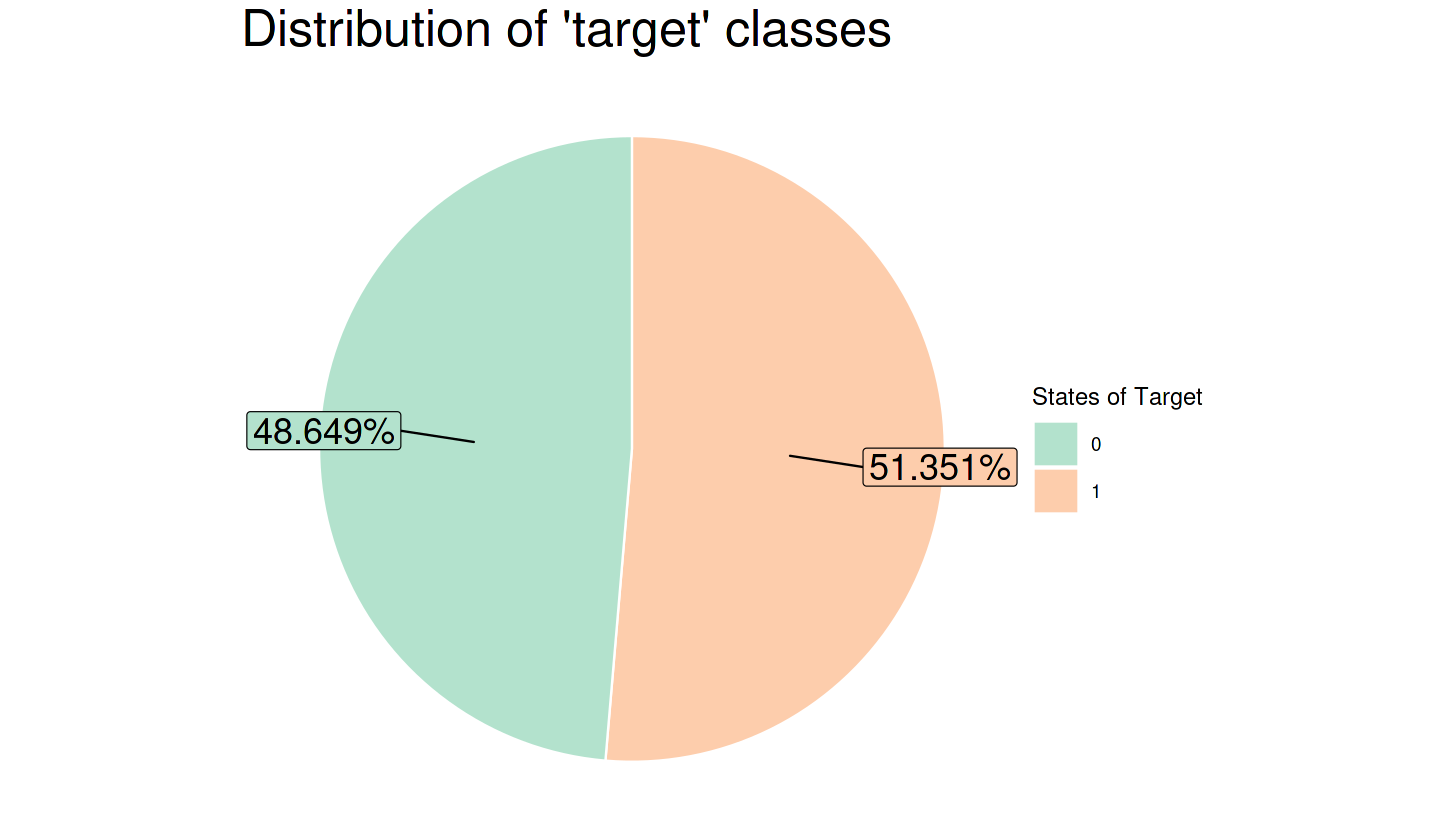

In [5]:
#Creating a pie chart
pie_maker(df_train, c("Target", "States of Target")) + ggtitle("Distribution of 'target' classes") + theme(plot.title = element_text(size = 30))

Classes seem to be balanced with a very slight lead by '1' state.

In [6]:
head(df_train[, 1:18])
head(df_train[, 19:length(df_train)])

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,-1.3732464,0.2388873,-0.2433761,0.5674049,-0.6477146,0.8393265,0.1131329,1,5,1,3,3,3,1,6,1,0
2,1,1.6970206,-1.7103224,-2.2303325,-0.5456608,1.1131725,-1.5521747,0.4478253,1,3,4,0,2,3,0,1,0,4
3,2,1.6817256,0.6167456,-1.0276892,0.8104919,-0.6090864,0.1139651,-0.7086596,1,0,2,6,6,4,3,1,2,2
4,3,-0.1181718,-0.5878348,-0.8046375,2.0868221,0.3710055,-0.1288310,-0.2825754,3,2,1,0,1,6,4,2,3,3
5,4,1.1484814,-0.1765668,-0.6648715,-1.1013430,0.4678754,0.5001172,0.4075153,3,3,0,4,3,0,6,0,3,3
6,5,1.3497850,1.1004180,0.5626115,-0.6070758,1.2647284,0.2835153,-1.1319535,6,2,4,2,1,6,3,1,1,1


,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>
1,7,4,0.2982180,-0.9197168,3.0585409,-2.5407389,0.7669520,-2.730628233,-0.2081775,1.36340240,ABABDADBAB,67.60915,0,0,0
2,6,0,-3.1476670,-1.0754343,2.1790500,2.2783149,-0.6336583,-1.217077123,-3.7821941,-0.05831594,ACACCADCEB,377.09642,0,0,1
3,1,4,2.8207329,-3.4853422,-0.7842352,-1.3857750,-0.5205578,-0.009121448,2.7885359,-3.70348800,AAAEABCKAD,-195.59970,0,2,1
4,0,3,1.0810836,-2.1001775,-2.3438189,0.5725941,-1.6532129,1.686034842,-2.5330978,-0.60860077,BDBBAACBCB,210.82621,0,0,1
5,1,0,-0.1261789,0.6050332,1.1336653,-3.9129291,-1.4303661,2.127648735,-3.3067843,4.37137106,BDBCBBCHFE,-217.21180,0,1,1
6,0,2,0.9987515,3.3587232,0.4639358,-2.2597808,-1.3083291,-2.216110493,1.0168919,0.27379188,BDAEDBDEDA,45.89100,0,1,0


In [7]:
#Removing unnecessary (for this summary) features
df_stats <- df_train %>%
    dplyr::select(-c(1,29,33))

#Generating columns of min, max and mean values for each feature
df_stats <- df_stats %>%
  pivot_longer(everything()) %>%
  group_by(name) %>% 
  summarise_at("value", list(~min(.), ~max(.), ~mean(.),  ~sd(.), ~skewness(.)))

df_stats <- t(df_stats) #Transposing changed dataframe/matrix

head(df_stats[, 1:15])
head(df_stats[, 16:30])

name,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14
min,-4.599856,-4.682199,-4.642676,-4.658816,-4.748501,-4.750214,-4.842919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.749301,4.815699,4.961982,4.454920,4.948983,4.971881,4.822668,15.000000,16.000000,14.000000,14.000000,13.000000,16.000000,12.000000,14.000000
mean,-0.0002861668,0.0011653114,0.0011740882,-0.0013683675,-0.0005706997,0.0002843946,-0.0007094587,2.0314600000,2.0579977778,2.3624311111,2.1776366667,1.8033922222,2.8423733333,2.2397777778,1.5146855556
sd,0.9988878,0.9991927,1.0005145,1.0001749,1.0001665,0.9998749,0.9999420,1.6561723,1.5909547,1.6377064,1.6459527,1.5374872,1.7628347,1.5384257,1.3592129
skewness,-0.0027200410,-0.0015580593,-0.0065413179,0.0030947007,0.0054476301,-0.0011302903,0.0001511235,0.9584583436,0.9002112255,0.7501599434,0.8088299843,0.9718100139,0.6317187405,0.7163404742,1.0110420666


name,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30
min,0.000000,0.000000,0.000000,0.000000,-11.280941,-11.257917,-13.310146,-11.853530,-12.301097,-11.416189,-11.918306,-14.300577,-1229.753052,0.000000,0.000000
max,14.000000,15.000000,14.000000,13.000000,12.079667,11.475325,14.455426,11.344080,12.247100,12.389844,12.529179,12.913041,1229.562577,1.000000,2.000000
mean,2.1011322222,2.0967133333,1.8585177778,2.0651311111,0.3087130395,-0.1787304152,-0.1563070364,-0.0092732747,-0.3694586703,-0.3427379289,0.1765488727,0.3575905461,-0.3808764219,0.3456611111,1.0026544444
sd,1.5690933,1.5601689,1.4676749,1.5647835,2.3160259,2.4004941,2.4847060,2.4507975,2.4534051,2.3869412,2.4169588,2.4760201,238.7730540,0.4755836,0.8189894
skewness,0.8324996832,0.7882591787,0.8406848351,0.8162327939,-0.0592020648,0.0102048342,0.0026878997,-0.0786368140,0.0502943375,0.0010505168,-0.0029839934,-0.1208772523,-0.0055410154,0.6490497908,-0.0048912569


Ranges of features get different as the suffixes rise. ['f_00' - 'f06'], ['f19' - 'f26'] these two groups have vastly diffent ranges and have a symmetrical distribution (skewness is very close to 0 for 'double' type variables). Although feature f_28 stands out with its range it also has a symmetrical distribution.

First group: ['f_00' - 'f06'] has a standard Gaussian distribution - mean = 0 and sd = 1. Second group: ['f19' - 'f26']  slightly varies.

**Correlation**

Checking correlation between features.

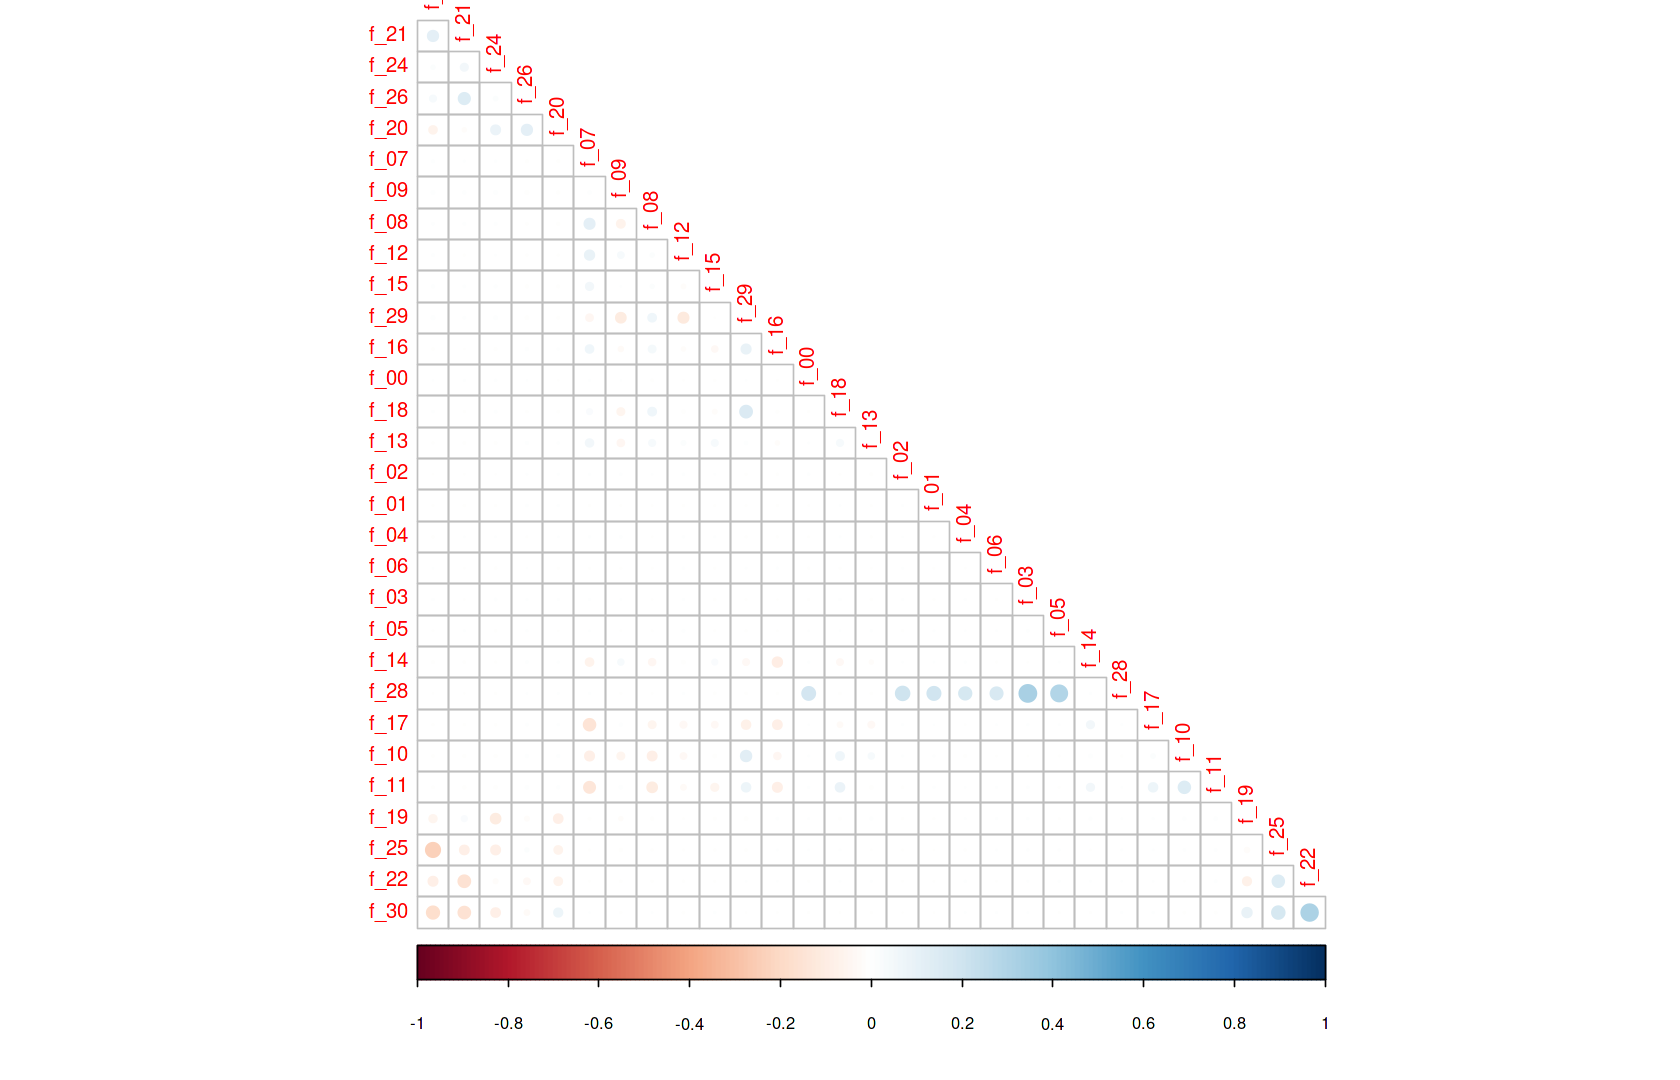

In [8]:
options(repr.plot.width = 14, repr.plot.height = 9)
df_train %>%
    dplyr::select(-c(1,29,33)) %>%
    cor() %>%
    corrplot(method = "circle", order = 'FPC', type = 'lower', diag = FALSE)

**Feature interactions**

Since the theme of this playground excercise is interactions between features, I'll be trying and most probably missing different combinations of statistics. Do previously established groups have a negative mean / how do integer features come into play / counting the letters and checking if feature_27 starts with an 'A'.

For the latter part, in previous runs of the notebook, count of letter A achieved the highest score. Combined ranked score also was an important feature. As it turns out, models could learn the most by splitting feature_27 into 10 separate columns because of the importance of letter placement. Combined ranked score was kind of a botched version of this split.

To start off, I'm tinkering with feature_27. Counting number of letters and also creating a sum (where A = 1 and Z = 26).

In [9]:
data_prep <- function(df, is_test = NULL) {

#Counting unique characters
unique_vec <- c()
for(i in 1:nrow(df))
    unique_vec[i] <- length(unique(strsplit(df$f_27[i], "")[[1]]))       
 
    

#Checking if the changes are being made on a test or train set
if(missing(is_test) || is_test == FALSE) {

#Counting how many times does each letter appear in the string
df <- df %>%
    mutate(A_start =  ifelse(substr(f_27, 1,1) == 'A', 1,0))


    

for(i in letters[1:26]) {
    
    df <- df %>%
        mutate(temp = str_count(f_27, toupper(i)))
    
    colnames(df)[length(df)] <- paste('letter', toupper(i), sep = '_')
}



ranked_letters_sum <- 0

for(j in 1:26) {
    ranked_letters_sum <- ranked_letters_sum + j*df[, j+33] 
                }

df <- df %>%
    cbind(ranked_letters_sum)
 
#Leaving A letter count and removing others
df <- df[, -c(36:60)]

    
#Splitting feature_27 into 10 columns
df <- df %>%
    mutate(f_27 = sub("\\s+$", "", gsub('(.{1})', '\\1 ', f_27))) #This is a roundabout way of splitting it - I'm adding spaces between letters and then using a function that acts on those spaces


df <- df %>% separate(f_27, into = c('First_Position', 'Second_Position', 'Third_Position',
                                           'Fourth_Position', 'Fith_Position', 'Sixth_Position', 'Seventh_Position',
                                           'Eighth_Position', 'Ninth_Position', 'Tenth_Position'))

#Changing letters to unique integer values
df <- df %>%
    mutate(across(c(29:38), ~match(.x, toupper(letters[1:26]))))

#Binding unique characters column
df <- df %>%
    cbind(unique_char_count = unique_vec)
    
    
#Removing id column
df <- df[, -1]


    
    
df <- df %>% 
    dplyr::select(-target, target) #Putting target variable back at the end of the dataframe


    } else if(!missing(is_test) && is_test == TRUE) {
    
       #Counting how many times does each letter appear in the string
        df <- df %>%
            mutate(A_start =  ifelse(substr(f_27, 1,1) == 'A', 1,0))


    for(i in letters[1:26]) {
    
        df <- df %>%
            mutate(temp = str_count(f_27, toupper(i)))
    
        colnames(df)[length(df)] <- paste('count_letter', toupper(i), sep = '_')
                            }



    ranked_letters_sum <- 0

    for(j in 1:26) {
        ranked_letters_sum <- ranked_letters_sum + j*df[, j+32] 
                    }
    
    df <- df %>%
        cbind(ranked_letters_sum)

#Leaving A letter count and removing others
df <- df[, -c(35:59)]

 #Splitting feature_27 into 10 columns   
df <- df %>%
    mutate(f_27 = sub("\\s+$", "", gsub('(.{1})', '\\1 ', f_27))) #This is a roundabout way of splitting it - I'm adding spaces between letters and then using a function that acts on those spaces


df <- df %>% separate(f_27, into = c('First_Position', 'Second_Position', 'Third_Position',
                                           'Fourth_Position', 'Fith_Position', 'Sixth_Position', 'Seventh_Position',
                                           'Eighth_Position', 'Ninth_Position', 'Tenth_Position'))

    

#Changing letters to unique integer values
df <- df %>%
    mutate(across(c(29:38), ~match(.x, toupper(letters[1:26]))))

#Binding unique characters column
df <- df %>%
    cbind(unique_char_count = unique_vec)

    
#Removing id column
df <- df[, -1]
}

    
#Scaling continuous variables to a (0,1) range
        
    
return(df)
    }

**Augmenting data**

In [10]:
df_train <- data_prep(df_train)

# Feature interactions - iml package

This analysis is inspired by @wti200's [discussion](https://www.kaggle.com/competitions/tabular-playground-series-may-2022/discussion/323766) about correlation and interaction.

Feature interactions option from ['iml' package ](https://cran.r-project.org/web/packages/iml/iml.pdf) uses Friedman’s H-statistic. The package is time consuming and to limit the number of created notebooks, I used a sample size of 0.04  for the plot and 0.005 for the data frame. Results may possibly hold no useful information at all. To check interactions more thoroughly the sample size / number of notebooks could be incrased  and 2-way interactions would be examined one by one.


Due to functions overlap with other used packages, feature interactions were calculated in another notebook. This is the result for the 'target' variable:

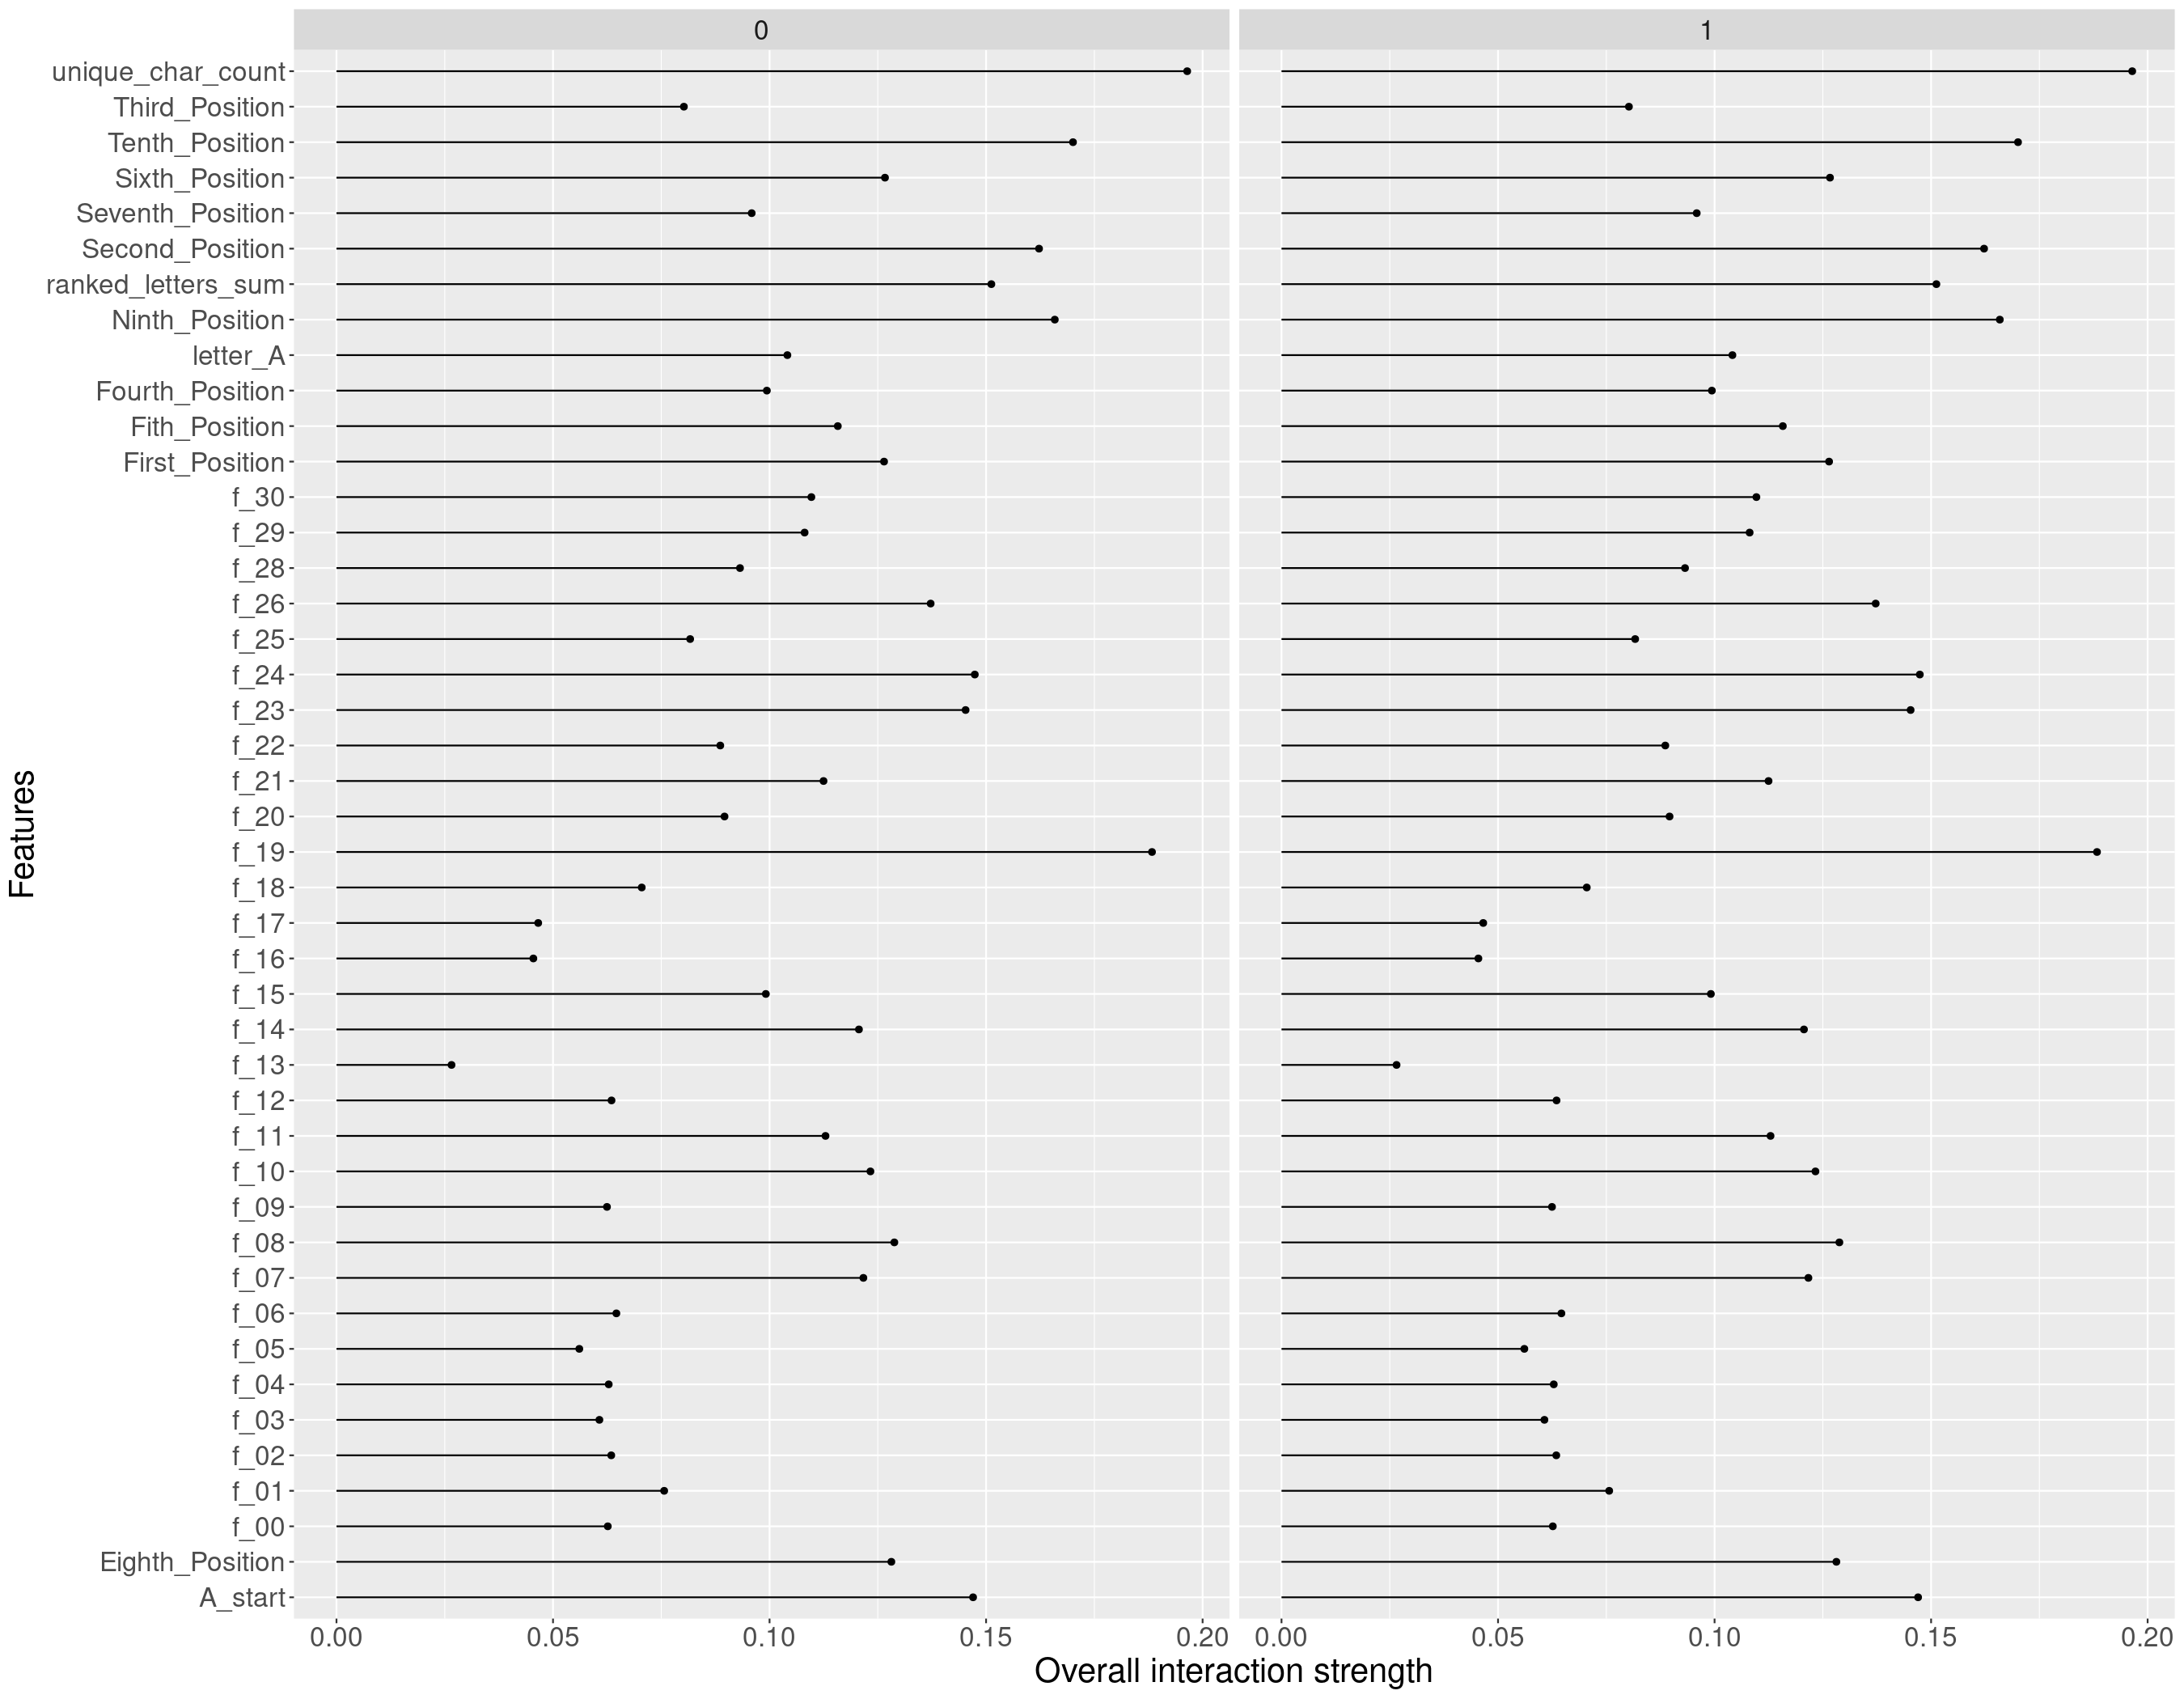

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     2700   2100 sRGB       FALSE   105646 59x59  


In [11]:
feat_int_img <- magick::image_read('../input/may-r-iml-package-feature-interactions/target_interactions.png')
print(feat_int_img) 

Interaction strengths are equal for both class outcomes - 0 or 1. After building a random forest with 250 trees checking for interactions *Tenth_position* feature had the highest score, akin to the 'score' given by the sequential addition.
To save on the number of additional notebooks, I reduced the number of random forest trees to 200. Interaction results are a little different, with *unique_char_count*, followed by *f_19* and then *Tenth_position* / *Ninth_position* features based on score.

Iml package also allows to check  2-way interactions, although just like the interactions above, it's time consuming.

For a deeper dive and better undestanding check [Christoph Molnar's Book on 'Interpretable Machine Learning'](https://christophm.github.io/interpretable-ml-book/). It contains theory concering iml, no knowledge of R needed.

**2-way interactions between standard features**

2-way interactions are not mutual, i.e. interaction strength between two features can vary based on the examined feature.
This will be illustrated in tables below.

In [12]:
df_interactions <- read.csv("../input/may-r-iml-package-feature-interactions/standard_interactions.csv")

In [13]:
df_interactions <- clean_names(df_interactions)

df_interactions <- df_interactions %>%
    filter(class == 0) %>% 
    dplyr::select(-class) %>%
    group_by(feature_group) %>%
    arrange(interaction, .by_group = TRUE) %>%
    top_n(n = 1, interaction) %>%
    t()

In [14]:
df_interactions[, 1:15]

feature_group,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
feature,f_28:f_00,f_23:f_01,f_28:f_02,f_28:f_03,f_28:f_04,f_28:f_05,f_28:f_06,f_14:f_07,f_28:f_08,f_29:f_09,f_14:f_10,f_14:f_11,f_29:f_12,f_06:f_13,f_07:f_14
interaction,0.26404144,0.23802238,0.38811727,0.22811109,0.36546833,0.38478430,0.25651239,0.36126739,0.17492023,0.22647550,0.11558483,0.24398957,0.36495620,0.09515105,0.39017633


In [15]:
df_interactions[ ,16:29]

feature_group,16,17,18,19,20,21,22,23,24,25,26,27,28,29
feature,f_29:f_15,f_07:f_16,f_29:f_17,f_07:f_18,f_30:f_19,f_23:f_20,f_25:f_21,f_24:f_22,f_19:f_23,f_30:f_24,f_30:f_25,f_19:f_26,f_02:f_28,f_17:f_29
interaction,0.14481313,0.22614718,0.36738016,0.11702509,0.29762796,0.34774619,0.23043555,0.33618798,0.24059122,0.47114187,0.32326614,0.17961422,0.64853104,0.41330081


Due to a small sample size, these interactions may not be truthful to the whole dataset. These two tables show that the interaction strength of x:y doesn't necessarily match the interaction strength of y:x (f_28:any_feature / f_02:f_28).

Features that stand out the most (from this table): f_28, f_14, f_29.  

**Gathering probability data**

In [16]:
#0.2 holdout dataset
set.seed(10)
holdout_rows <- sample(nrow(df_train), size = floor(0.2*nrow(df_train)))
probs_holdout <- df_train[holdout_rows, ]

    
probs_model <- h2o4gpu.gradient_boosting_classifier(loss = "deviance", learning_rate = 0.05,
                    n_estimators = 500, subsample = 1, criterion = "friedman_mse",
                    min_samples_split = 2, min_samples_leaf = 1,
                    min_weight_fraction_leaf = 0, max_depth = 12, min_impurity_decrease = 0,random_state = 1077,
                    max_features = "auto", verbose = 0,
                    warm_start = FALSE, presort = "auto", colsample_bytree = 1,
                    tree_method = "gpu_hist", 
                    predictor = "gpu_predictor", objective = "binary:logistic",
                    booster = "gbtree", gamma = 0, colsample_bylevel = 1, reg_alpha = 0,
                    reg_lambda = 1, scale_pos_weight = 1, base_score = 0.5,
                    backend = "h2o4gpu") %>% fit(df_train[-holdout_rows, -length(df_train)], df_train[-holdout_rows, length(df_train)])

probs_predictions <- round(predict(probs_model, probs_holdout[, -length(probs_holdout)], type = 'prob')[, 2])

#Scaling continuous variables
probs_holdout <- probs_holdout %>%
    mutate(across(c(1:7,20:26,38), ~BBmisc::normalize(.x, method = 'range', range = c(0,1))))


#Binding predictions to the holdout dataset
probs_holdout <- probs_holdout %>%
    cbind(probs_predictions = as.factor(probs_predictions))

**Creating scatter plots of supposed feature interactions**

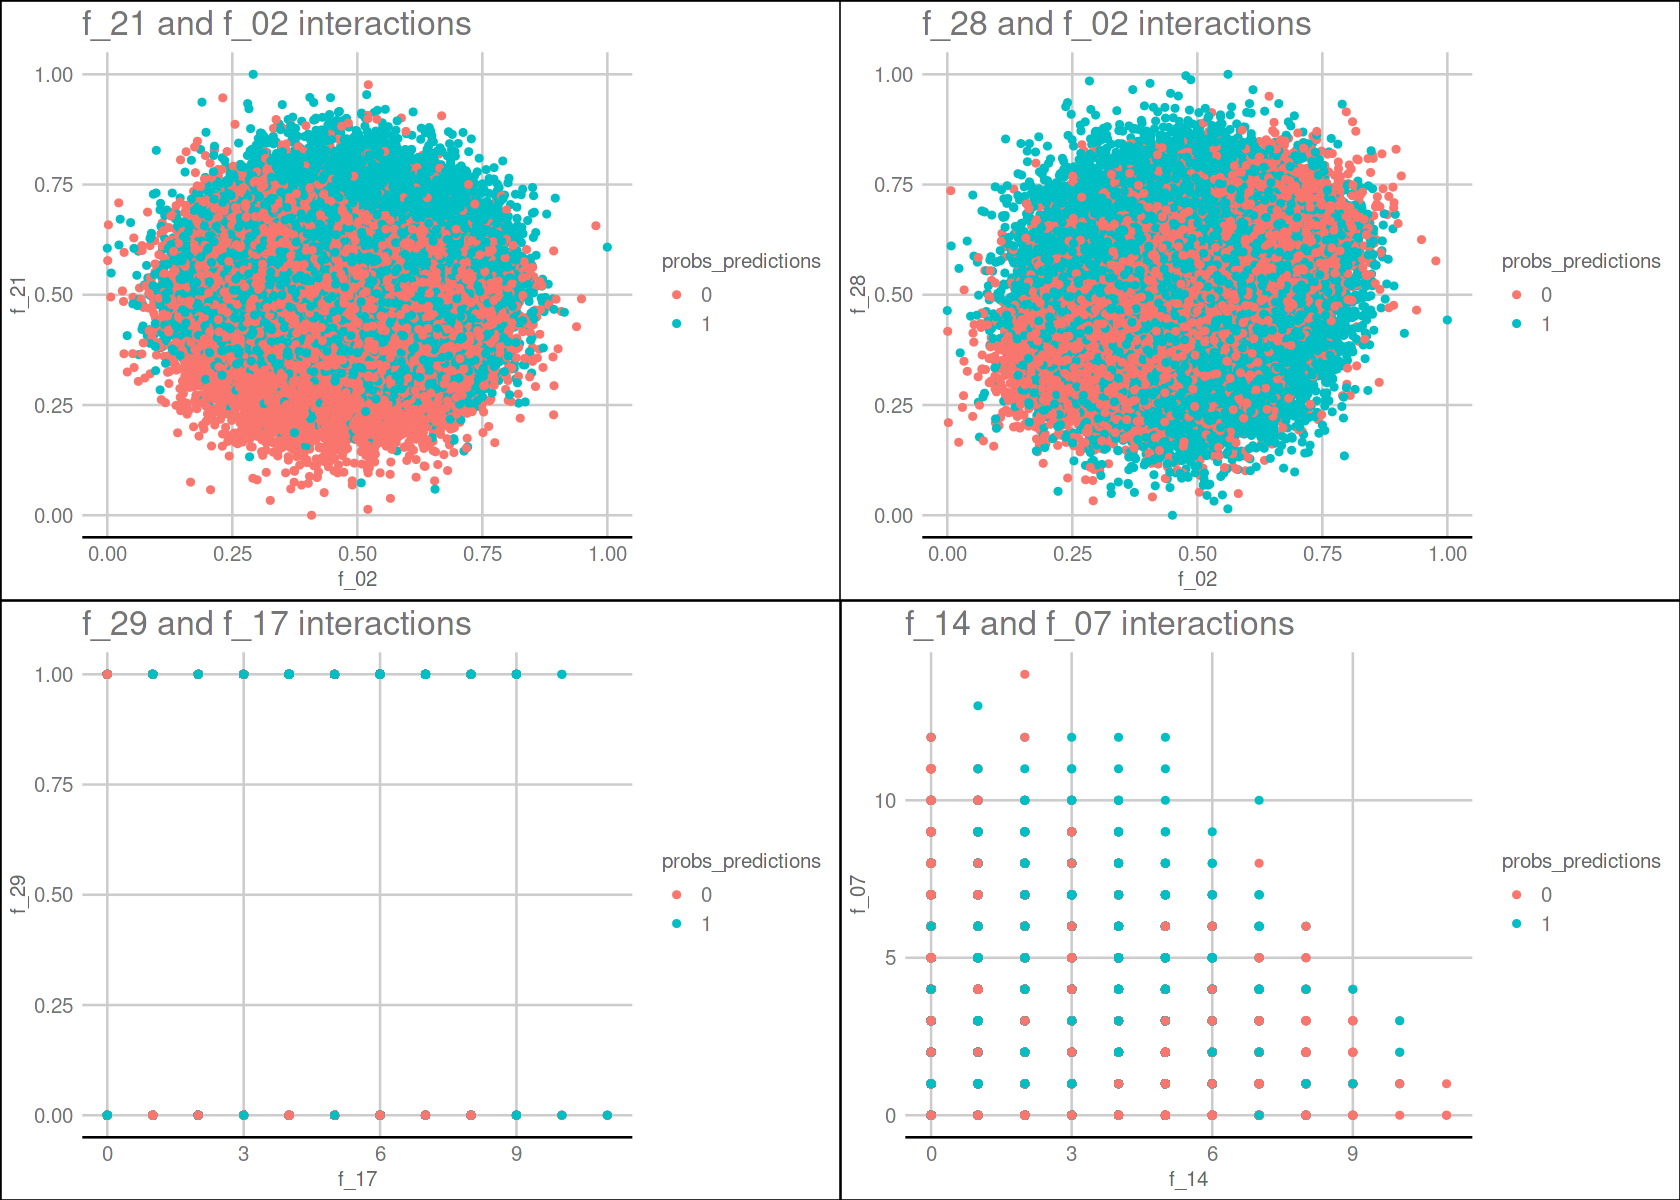

In [17]:
#Discussed interaction
p_02_21 <- ggplot(probs_holdout, aes(x = f_02, y = f_21)) + geom_point(aes(colour = probs_predictions)) + theme_gdocs() + ggtitle("f_21 and f_02 interactions")

#Supposed interactions
p_02_28 <- ggplot(probs_holdout, aes(x = f_02, y = f_28)) + geom_point(aes(colour = probs_predictions)) + theme_gdocs() + ggtitle("f_28 and f_02 interactions")
p_17_29 <- ggplot(probs_holdout, aes(x = f_17, y = f_29)) + geom_point(aes(colour = probs_predictions)) + theme_gdocs() +  ggtitle("f_29 and f_17 interactions")
p_14_07 <- ggplot(probs_holdout, aes(x = f_14, y = f_07)) + geom_point(aes(colour = probs_predictions)) + theme_gdocs() + ggtitle("f_14 and f_07 interactions")

options(repr.plot.width = 14, repr.plot.height = 10)
plot_grid(p_02_21, p_02_28, p_17_29, p_14_07, ncol = 2, nrow = 2)

* Interactions of features f_28 and f_02 show, that class '1' appears mainly in upper left and lower right quadrants.

* Interactions between features f_29 and f_17 can be interpreted as f_29 * f_17 > 0 - when f_29 == 1 and f_17 > 0, it's class '1'

* f_14 and f_07 interactions are not as discernible - some assumptions could be made based on f_14: 2,4 and 5 values.

**Creating variables based on feature interactions**

In [18]:
feature_interact <- function(df) {

#Interactions between f_21 and f_02
    f_21xf_02 <- as.integer(df$f_21 + df$f_02 > 5.2) - as.integer(df$f_21 + df$f_02 < -5.3)
  

#Scaling f_02 and f_28 features to a (0,1) range
    df <- df %>%
        mutate(f_28 = normalize(f_28, method = 'range', range = c(0,1)),
               f_02 = normalize(f_02, method = 'range', range = c(0,1)))
               
#Interactions between f_28 and f_02
    f_28xf_02 <- rep(0, nrow(df))
    f_28xf_02 <- f_28xf_02 + if_else(df$f_28 - 0.25 - df$f_02 > 0, 1,-1)
    f_28xf_02 <- f_28xf_02 + if_else(df$f_28 + 0.25 - df$f_02 < 0, -1, 1)

    f_28xf_02 <- f_28xf_02/2
 
    
#Interactions between f_29 and f_17
    f_29x_f_17 <- as.integer(df$f_29*df$f_17 > 0)
    
    df <- df %>%
        cbind(f_29x_f_17 = f_29x_f_17) %>%
        cbind(f_21xf_02 = f_21xf_02) %>%
        cbind(f_28xf_02 = f_28xf_02)
        
}

df_train <- feature_interact(df_train)

#Reselecting target to last place
df_train <- df_train %>%
    dplyr::select(-target, target)

# Sprouting trees from the ground up

**Grid search function**

In [19]:
#dataset = data.frame object, model_type = h2o4gpu classifier model, params = list of parameters*, return_n = how many observations should be returned
#k - number of folds; if NULL, k = 10, which_fold - setting a seed to check on the same fold; if NULL, last fold is chosen
#params = depending on model type - list of n parameter arrays, custom holdout - whether to use a custom holdout
h2o4gpu_grid_search <- function(dataset, model_type, params, return_n, k = NULL, which_fold = NULL, custom_holdout = NULL) {

#Dataset split
if(missing(k) || (is.null(k))) {
    k_grid <- 10
} else if(!missing(k))
        k_grid <- k



if(missing(which_fold) || (is.null(which_fold))) {
   sampled_k <- k_grid 
} else if(!missing(which_fold))
          sampled_k <- which_fold
    
    

if(missing(custom_holdout) ||(is.null(custom_holdout))) {
holdout_rows <- c(((sampled_k-1)*floor((nrow(dataset)/k_grid))+1):((floor(nrow(dataset)/k_grid))*sampled_k)+nrow(dataset)%%k_grid)
} else if(!missing(custom_holdout)) {

holdout_rows <- c((nrow(dataset)+1):(nrow(dataset)+nrow(custom_holdout))) #Datasets are bound and holdout rows are assumed to be bound rows
    dataset <- dataset %>%
    rbind(custom_holdout)
}




if(model_type == 'rf') {
    
df_grid <- data.frame(n_estimators = 0, max_depth = 0, colsample_bytree = 0, subsample = 0, AUC = 0) 
    

        rf_n_estimators <- params[[1]]
        rf_max_depth <- params[[2]]
        rf_colsample_bytree <- params[[3]]
        rf_subsample <- params[[4]]
    
#Brute grid search loops
for(i in rf_n_estimators){
  for(j in rf_max_depth){
    for(k in rf_colsample_bytree){
      for(l in rf_subsample){
        
    rf_model_class <- h2o4gpu.random_forest_classifier(n_estimators = i, criterion = "entropy",
    max_depth = j, colsample_bytree = k,
    subsample = l, random_state = 1212, max_features = "auto",
    verbose = 0, tree_method = "gpu_hist",
    predictor = "gpu_predictor", backend = "h2o4gpu") %>% fit(as.data.frame(dataset[-holdout_rows, -length(dataset)]), dataset[-holdout_rows, length(dataset)])

        
        df_grid <- df_grid %>%
          rbind(c(i,j,k,l, AUC(predictions = predict(rf_model_class,
                                  as.data.frame(dataset[holdout_rows, -length(dataset)]), type = "prob")[, 2],
                                  labels = dataset[holdout_rows, length(dataset)])))
        
                          }
                        }
                      }
                    }
    
    
    
        df_grid <- df_grid %>%
        arrange(desc(AUC)) %>%
        head(return_n)     
    

}     else if(model_type == 'gb') {

df_grid <- data.frame(learning_rate = 0, n_estimators = 0, max_depth = 0, colsample_bytree = 0, subsample = 0, AUC = 0) 
    

        gb_learning_rate <- params[[1]]
        gb_n_estimators <- params[[2]]
        gb_max_depth <- params[[3]]
        gb_colsample_bytree <- params[[4]]
        gb_subsample <- params[[5]]

    
#Brute grid search loops
for(i in gb_learning_rate) {
    for(j in gb_n_estimators) {
      for(k in gb_max_depth) {
        for(l in gb_colsample_bytree){
          for(n in gb_subsample) {
        
    gb_model_class <- h2o4gpu.gradient_boosting_classifier(loss = "deviance", learning_rate = i,
                n_estimators = j, subsample = n, criterion = "friedman_mse",
                min_weight_fraction_leaf = 0, max_depth = k, min_impurity_decrease = 0,random_state = 1212,
                max_features = "auto", verbose = 0,
                warm_start = FALSE, presort = "auto", colsample_bytree = l,
                tree_method = "gpu_hist", 
                predictor = "gpu_predictor", objective = "binary:logistic",
                booster = "gbtree", gamma = 0, colsample_bylevel = 1, reg_alpha = 0,
                reg_lambda = 1, scale_pos_weight = 1, base_score = 0.5,
                backend = "h2o4gpu") %>% fit(as.data.frame(dataset[-holdout_rows, -length(dataset)]), dataset[-holdout_rows, length(dataset)])
              
        df_grid <- df_grid %>%
          rbind(c(i,j,k,l, n, AUC(predictions = predict(gb_model_class,
                                  as.data.frame(dataset[holdout_rows, -length(dataset)]), type = "prob")[, 2],
                                  labels = dataset[holdout_rows, length(dataset)])))
        
                                  }
                                 }
                                }
                               }
                              }
#Arranging by AUC
    df_grid <- df_grid %>%
        arrange(desc(AUC))
}

#Removing an empty row
df_grid <- df_grid[-nrow(df_grid), ]

df_grid <- df_grid %>%
    head(return_n)

return(df_grid)
}

**Finding parameters**

In [20]:
gb_params <- list(c(0.05), c(400), c(10), c(0.75),c(1))

h2o4gpu_grid_search(df_train, model_type = 'gb', params = gb_params, return_n = 5, k = 5, which_fold = 3)

,learning_rate,n_estimators,max_depth,colsample_bytree,subsample,AUC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.05,400,10,0.75,1,0.9866121


# Sequential feature evaluation

In [21]:
evaluate_feats <- function(dataset, model_type, topdown = NULL) {

used_cols <- c()
improvement <- 1

#Sampling (0.05 sample)
set.seed(10)
holdout_rows <- sample(nrow(dataset), size = floor(0.025*nrow(dataset)))
dataset <- dataset[holdout_rows, ]
    

#Sampling once more (0.2 sample)
set.seed(5)
holdout_rows <- sample(nrow(dataset), size = floor(0.2*nrow(dataset)))
holdout_dataset <- dataset[holdout_rows, ]
dataset <- dataset[-holdout_rows, ]

#Evaluating features
feature_cols <- c(1:(length(dataset)-1))
selected_cols <- c()
used_feats <- c(length(dataset))
  
#Tweaking data to fit chosen model type
if(model_type == 'gb') {
    model_params <- list(c(0.05), c(200), c(7), c(1), c(1))
    auc_column <- 6 } else if(model_type == 'rf') {
                              model_params <- list(c(200), c(7), c(1), c(1))
                              auc_column <- 5     }
last_model_auc <- 0
    
if(!is.null(topdown) && topdown == TRUE) {
    last_model_auc <- h2o4gpu_grid_search(dataset, model_type, model_params, return_n = 1, custom_holdout = holdout_dataset)[1,auc_column]
    used_feats <- c()
}
    
#Creating a while loop that checks for model improvement
while(improvement > 0) { 

    auc_df <- data.frame(var_name = 'blank', added_feat = as.numeric(0)) 
    
    tic()

#This if / else if solution isn't effective  - conditions are checked every while loop iteration; Alternatively code could be copied with minor alterations
        if(topdown == FALSE || is.null(topdown)) {
                for(i in feature_cols) {
                   add_auc <- last_model_auc -  h2o4gpu_grid_search(dataset[, c(i, used_feats)], model_type, model_params, return_n = 1, custom_holdout = holdout_dataset[, c(i, used_feats)])[1,auc_column]
                    
                   auc_df <- auc_df %>%
                   rbind(c(colnames(dataset)[i], add_auc))
                    
                                        }        
                                                 } else if(!is.null(topdown) && topdown == TRUE) {
         for(i in feature_cols) {
            add_auc <- last_model_auc - h2o4gpu_grid_search(dataset[, -c(i,used_feats)], model_type, model_params, return_n = 1, custom_holdout = holdout_dataset[, -c(i,used_feats)])[1,auc_column]                                
            
            auc_df <- auc_df %>%
            rbind(c(colnames(dataset)[i], add_auc))
                                }
                                                                                                 }
            

    auc_df <- auc_df[-1, ]  #Removing bespoke empty row
    auc_df[, 2] <- as.numeric(auc_df[, 2])

    used_feats <- append(c(which(colnames(dataset) == auc_df[which(auc_df$added_feat == min(auc_df$added_feat))[1], 1])), used_feats)  #Adding best performing feature to the vector
      

    #Removing used cols from feature_cols
    feature_cols <- feature_cols[-which(feature_cols == (which(colnames(dataset) == auc_df[which(auc_df$added_feat == min(auc_df$added_feat))[1], 1])))]

    improvement <- min(auc_df$added_feat)*(-1) #If the expanded model is better, added_feat will be negative, hence the *(-1)
    last_model_auc <- last_model_auc + improvement

    if(improvement >0) { #Printing only when model improves
        cat(sprintf("Variable added / removed: %s\n", auc_df[which(auc_df$added_feat == min(auc_df$added_feat))[1], 1]))
        cat(sprintf("AUC improvement: %s\n", improvement))
        cat(sprintf("New AUC: %s\n", last_model_auc))
        flush.console() 
        toc()              
                        
        used_cols <- append(used_cols, auc_df[which(auc_df$added_feat == min(auc_df$added_feat))[1], 1])
                      }
                                            }
                 
    
    
return(used_cols)
                                            }

In [22]:
evaluate_feats(df_train, model_type = 'gb')

Variable added / removed: Tenth_Position
AUC improvement: 0.593178109137997
New AUC: 0.593178109137997
34.822 sec elapsed
Variable added / removed: unique_char_count
AUC improvement: 0.0327161927732279
New AUC: 0.625894301911225
61.188 sec elapsed
Variable added / removed: f_21xf_02
AUC improvement: 0.0298406077170572
New AUC: 0.655734909628282
58.312 sec elapsed
Variable added / removed: Third_Position
AUC improvement: 0.0299541839856476
New AUC: 0.68568909361393
55.516 sec elapsed
Variable added / removed: f_07
AUC improvement: 0.0329641033751618
New AUC: 0.718653196989091
58.731 sec elapsed
Variable added / removed: A_start
AUC improvement: 0.0220734341252715
New AUC: 0.740726631114363
60.269 sec elapsed
Variable added / removed: f_10
AUC improvement: 0.0251561055893551
New AUC: 0.765882736703718
61.681 sec elapsed
Variable added / removed: Fith_Position
AUC improvement: 0.0270003113709718
New AUC: 0.79288304807469
62.945 sec elapsed
Variable added / removed: f_29
AUC improvement: 0

[1] "Tenth_Position"    "unique_char_count" "f_21xf_02"        
 [4] "Third_Position"    "f_07"              "A_start"          
 [7] "f_10"              "Fith_Position"     "f_29"             
[10] "Ninth_Position"    "Sixth_Position"    "f_15"             
[13] "f_26"              "f_11"              "f_22"             
[16] "Second_Position"   "f_08"              "f_14"             
[19] "f_05"              "f_00"              "f_01"             
[22] "f_28"              "Eighth_Position"   "f_30"             
[25] "f_24"              "f_25"              "f_02"             
[28] "Fourth_Position"   "f_23"              "f_19"             
[31] "f_04"              "f_13"

In [27]:
evaluate_feats(df_train, model_type = 'gb', topdown = TRUE)

Variable added / removed: f_06
AUC improvement: 0.000863535493834222
New AUC: 0.952331377791844
102.257 sec elapsed


[1] "f_06"

**Sequential addition - evaluation**

Approach of removing features from a fully fitted model seems to achieve better results, even if by a little.

# Time for predictions

In [28]:
#Loading in test data
df_test <- read.csv("../input/tabular-playground-series-may-2022/test.csv")

#Augmenting data
df_test <- data_prep(df_test, is_test = TRUE)

df_test <- feature_interact(df_test)

#Creating and fitting a  model
    gb_model <- h2o4gpu.gradient_boosting_classifier(loss = "deviance", learning_rate = 0.05,
                n_estimators = 1100, subsample = 1, criterion = "friedman_mse",
                min_samples_split = 2, min_samples_leaf = 1,
                min_weight_fraction_leaf = 0, max_depth = 14, min_impurity_decrease = 0,random_state = 2022,
                max_features = "auto", verbose = 0,
                warm_start = FALSE, presort = "auto", colsample_bytree = 1,
                tree_method = "gpu_hist", 
                predictor = "gpu_predictor", objective = "binary:logistic",
                booster = "gbtree", gamma = 0, colsample_bylevel = 1, reg_alpha = 0,
                reg_lambda = 1, scale_pos_weight = 1, base_score = 0.5,
                backend = "h2o4gpu") %>% fit(df_train[, -c(7,length(df_train))], df_train[, length(df_train)])
                                                                                              
                                                                                              
                                                                                              
#Creating predictions                                                                                              
gb_predictions <- predict(gb_model, df_test[, -7], type = "prob")[, 2]                                                                                          

In [29]:
#Loading in the submission file
tree_submission <- read.csv("../input/tabular-playground-series-may-2022/sample_submission.csv")

tree_submission$target <- gb_predictions

write.csv(tree_submission, "./tree_sub.csv", quote = FALSE, row.names = FALSE)